In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
import tensorflow as tf
import os
import pickle
import json
import re
from PIL import Image

In [2]:
tf.test.is_gpu_available()

True

In [3]:
# make image dataloader using flow_from_dataframe
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# load data to extract labels
data_dir = '../mmhs150k/'
model_dir = 'models/'
tweet_dict = json.load(open(data_dir + 'MMHS150K_GT.json', 'r'))

In [4]:
from random import randint # for random cropping
from tensorflow.keras.preprocessing.sequence import pad_sequences

class MMDataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, splits_path, data_dict, tokenizer, pad_len, batch_size=32, dim=(299, 299), n_channels=3, shuffle=True):
        'Initialization'
        self.dim = dim
        self.data_dict = data_dict
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.pad_len = pad_len
        self.tokenizer = tokenizer
        
       # build labels list and id list
        self.id_list = open(splits_path, 'r').read().splitlines()
        self.labels = dict()
        for id in self.id_list:
            binary_labels = [1 if n > 0 else 0 for n in tweet_dict[id]['labels']]
            label = 1 if sum(binary_labels)/len(tweet_dict[id]['labels']) > 0.5 else 0
            self.labels[id] = label

        # create dictionary for embedded sequences (tuple of text and img_text)
        self.text_dict = self.process_text(self.id_list)
        
        self.on_epoch_end()
        self.classes = [self.labels[self.id_list[i]] for i in self.indexes]

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.id_list) / self.batch_size)) + 1 # last batch is partial

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:index*self.batch_size + self.batch_size]
        
        
        # Find list of IDs
        id_list_temp = [self.id_list[k] for k in indexes]

        # Generate data
        X_txt, X_img, y = self.__data_generation(id_list_temp)
        
        return (X_txt, X_img), y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.id_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, id_list_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X_img = np.empty((len(id_list_temp), *self.dim, self.n_channels))
        X_txt = np.empty((len(id_list_temp), self.pad_len))
        y = np.empty(len(id_list_temp), dtype=int)

       # Generate data
        for i, ID in enumerate(id_list_temp):
            # Store sample
            X_img[i,] = self.process_img(data_dir + 'img_resized/' + ID + '.jpg')
            X_txt[i,] = self.text_dict[ID]
            # Store class
            y[i] = self.labels[ID]
            
        return X_txt.astype(int), X_img, y

    
    def process_img(self, path): # method for getting image
        img = Image.open(path)
        img.load()
        scale_size = int(1.5 * self.dim[0]) # want cropping
        if img.size[0] < img.size[1]: # width greater than height
            wpercent = (scale_size/float(img.size[0]))
            hsize = int((float(img.size[1])*float(wpercent)))
            img = img.resize((scale_size,hsize), Image.ANTIALIAS)
        else: # height greater than width
            hpercent = (scale_size/float(img.size[1]))
            wsize = int((float(img.size[0])*float(hpercent)))
            img = img.resize((wsize, scale_size), Image.ANTIALIAS)
            
        data = np.asarray(img, dtype='uint8')
        im = self.augment(data) # apply transformation
        
        
        if im.shape==(self.dim[0], self.dim[1]): im = np.stack((im,)*3, axis=-1) # handle grayscale
        if im.shape == (*self.dim, 4): im = im[:,:,:3] # handle weird case
        
        return im
    
    def augment(self, im): # random crop and random mirror
        
        # random crop
        x_max, y_max = im.shape[0], im.shape[1]
        x_start, y_start = randint(0, x_max - self.dim[0]), randint(0, y_max - self.dim[1])
        im = im[x_start:x_start + self.dim[0], y_start:y_start + self.dim[1]]
        
        # random mirror
        if randint(0,1): im = np.flip(im, axis=1)
        
        return im
    
    def process_text(self, id_list):
        
        # matrix for texts
        texts = [self.data_dict[ID]['tweet_text'] for ID in id_list]
        sequences = [self.tokenizer.encode(text) for text in texts] # make this more efficient...
        text_seqs = pad_sequences(sequences, maxlen=self.pad_len)
        
        id_to_seq = {ID: txt for (ID, txt) in zip(id_list, text_seqs)} # map id to text seq
        
        return id_to_seq

In [5]:
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer, TFRobertaModel
# tokenizer = AutoTokenizer.from_pretrained('roberta-base')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
pad_len = 50

train_gen = MMDataGenerator(splits_path=data_dir + 'splits/train_ids.txt',
                          data_dict=tweet_dict,
                          tokenizer=tokenizer,
                          pad_len=pad_len,
                          batch_size=16,
                          dim=(224, 224),
                          n_channels=3,
                          shuffle=True)

val_gen = MMDataGenerator(splits_path=data_dir + 'splits/val_ids.txt',
                          data_dict=tweet_dict,
                          tokenizer=tokenizer,
                          pad_len=pad_len,
                          batch_size=16,
                          dim=(224, 224),
                          n_channels=3,
                          shuffle=True)

test_gen = MMDataGenerator(splits_path=data_dir + 'splits/test_ids.txt',
                          data_dict=tweet_dict,
                          tokenizer=tokenizer,
                          pad_len=pad_len,
                          batch_size=16,
                          dim=(224, 224),
                          n_channels=3,
                          shuffle=True)

# Define model

In [6]:
import transformers
from tensorflow.keras import layers

class BERT(transformers.TFBertModel):
    def __init__(self, config, *inputs, **kwargs):
        super(BERT, self).__init__(config, *inputs, **kwargs)
        self.bert.call = tf.function(self.bert.call)


class MyModel(tf.keras.Model):
    
    def __init__(self):
        super(MyModel, self).__init__()
        self.resnet = tf.keras.applications.resnet.ResNet152(include_top=False, 
                                                             weights='imagenet', 
                                                             input_shape=(224, 224, 3))
        self.bert = BERT.from_pretrained('bert-base-uncased')
        
        self.text_embedding = self.bert.get_input_embeddings().word_embeddings
         
        self.pooling = layers.AveragePooling2D(pool_size=(2, 2))
        self.reshape = layers.Reshape((3 * 3, 2048)) # 3 is from 7//2
        self.W_ns = [layers.Dense(self.bert.config.hidden_size) for _ in range(self.reshape.target_shape[0])]
        
        self.concat = layers.Concatenate(axis=1)
        
        self.dropout = layers.Dropout(0.1)
        self.denseout = layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        text, image = inputs
        
        # handle image
        image_emb = self.resnet(image)
        image_emb = self.pooling(image_emb)
        image_emb = self.reshape(image_emb)
        image_embeds = [self.W_ns[i](image_emb[:, i]) for i in range(self.reshape.target_shape[0])]
        image_emb = tf.keras.backend.stack(image_embeds, axis=1)
        # print(image_emb.shape) # does give (16, 9, 768) as desired
        
        # handle text
        text_emb = tf.gather(self.text_embedding, text)
        
        # concat and feed to bert
        concat_emb = self.concat([text_emb, image_emb])
        seg_ids = np.concatenate((np.zeros(pad_len, dtype=np.int64), 
                                  np.ones(self.reshape.target_shape[0], dtype=np.int64)))
        bert_encodings = self.bert(inputs={'inputs_embeds': concat_emb,
                                                'token_type_ids': seg_ids})[0]
        doc_encoding = tf.squeeze(bert_encodings[:, 0:1, :], axis=1)
        doc_encoding = self.dropout(doc_encoding)
        
        output = self.denseout(doc_encoding)
        
        return output

model = MyModel()

In [7]:
optimizer = tf.keras.optimizers.Adam(lr=5e-6)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])

In [8]:
# train model
from tensorflow.keras.callbacks import ModelCheckpoint

mcp_save = ModelCheckpoint(model_dir + 'best_bert_bt_weights.h5', 
                           save_weights_only=True, 
                           save_best_only=True, 
                           verbose=1,
                           monitor='val_auc', 
                           mode='max')

history = model.fit_generator(train_gen,
                    validation_data=val_gen,
                    shuffle=True,
                    epochs=5,
                    callbacks=[mcp_save])

Epoch 1/5
8426/8427 [============================>.] - ETA: 1s - loss: 0.4698 - accuracy: 0.7854 - auc: 0.6892
Epoch 00001: val_auc improved from -inf to 0.73657, saving model to models/best_bert_bt_weights.h5
8427/8427 [==============================] - 16670s 2s/step - loss: 0.4698 - accuracy: 0.7854 - auc: 0.6892 - val_loss: 0.7099 - val_accuracy: 0.6302 - val_auc: 0.7366
Epoch 2/5
8426/8427 [============================>.] - ETA: 1s - loss: 0.4564 - accuracy: 0.7984 - auc: 0.7401
Epoch 00002: val_auc improved from 0.73657 to 0.73929, saving model to models/best_bert_bt_weights.h5
8427/8427 [==============================] - 16733s 2s/step - loss: 0.4564 - accuracy: 0.7984 - auc: 0.7401 - val_loss: 0.7741 - val_accuracy: 0.5858 - val_auc: 0.7393
Epoch 3/5
8426/8427 [============================>.] - ETA: 1s - loss: 0.4456 - accuracy: 0.8026 - auc: 0.7557
Epoch 00003: val_auc did not improve from 0.73929
8427/8427 [==============================] - 16699s 2s/step - loss: 0.4456 - acc

In [9]:
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Model)            (None, 7, 7, 2048)        58370944  
_________________________________________________________________
bert (BERT)                  multiple                  109482240 
_________________________________________________________________
average_pooling2d (AveragePo multiple                  0         
_________________________________________________________________
reshape (Reshape)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  1573632   
_________________________________________________________________
dense_1 (Dense)              multiple                  1573632   
_________________________________________________________________
dense_2 (Dense)              multiple                  157

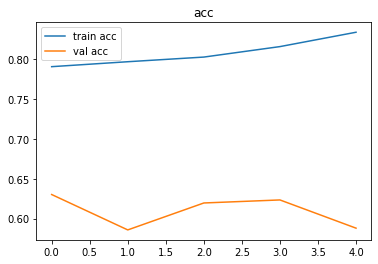

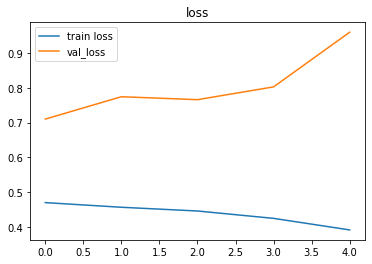

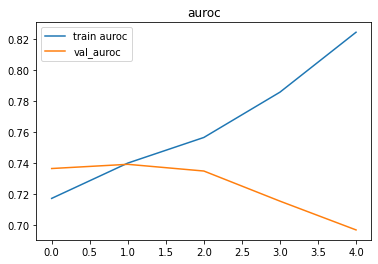

In [10]:
plt.plot(history.history['accuracy'], label = 'train acc')
plt.plot(history.history['val_accuracy'], label = 'val acc')
plt.legend()
plt.title('acc')
plt.show()

plt.plot(history.history['loss'], label = 'train loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()
plt.title('loss')
plt.show()

plt.plot(history.history['auc'], label = 'train auroc')
plt.plot(history.history['val_auc'], label = 'val_auroc')
plt.legend()
plt.title('auroc')
plt.show()

In [11]:
model.load_weights(model_dir + 'best_bert_bt_weights.h5')

In [13]:
# test
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
import math

y_test = test_gen.classes

# get AUROC
preds = model.predict_generator(test_gen)
print('Test AUROC:', roc_auc_score(y_test, preds))

# get loss and acc
preds_bin = np.array(preds)
preds_bin[preds>0.5] = 1
preds_bin[preds<=0.5] = 0
print('Test Accuracy:', accuracy_score(y_test, preds_bin))

# get F1
print('Test F1:', f1_score(y_test, preds_bin, zero_division=1))
print('Test Precision:', precision_score(y_test, preds_bin, zero_division=1))
print('Test Recall:', recall_score(y_test, preds_bin, zero_division=1))

Test AUROC: 0.73124596
Test Accuracy: 0.5822
Test F1: 0.3387147831592276
Test Precision: 0.8118361153262519
Test Recall: 0.214
